## Import and download datasets

In [1]:
import kagglehub

# Download the latest dataset version
data_dir = kagglehub.dataset_download("andrewmvd/dog-and-cat-detection")
print("Path to dataset files:", data_dir)

Path to dataset files: C:\Users\tienn\.cache\kagglehub\datasets\andrewmvd\dog-and-cat-detection\versions\1


## Import libraries

In [2]:
import os
import torch
import numpy as np

import pandas as pd
import seaborn as sns

import torch.nn as nn
import torch.optim as optim
import tqdm.notebook as tqdm

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import xml.etree.ElementTree as ET

from PIL import Image
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from torchvision.models.resnet import ResNet18_Weights

# Set the random seed for the reproducibility
seed = 123
torch.manual_seed(seed)

## Dataset Class with Bouding box Definition

In [3]:
# Dataset Class
class ImageDataset(Dataset):
    def __init__(self, annotations_dir, image_dir, transform=None):
        self.annotations_dir = annotations_dir
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = self.filter_images_with_multiple_objects()

    def filter_images_with_multiple_objects(self):
        valid_image_files = []
        for f in os.listdir(self.image_dir):
            if os.path.isfile(os.path.join(self.image_dir, f)):
                img_name = f
                annotation_name = os.path.splitext(img_name)[0] + ".xml"
                annotation_path = os.path.join(self.annotations_dir, annotation_name)

                if self.count_objects_in_annotation(annotation_path) == 1:
                    valid_image_files.append(img_name)

        return valid_image_files

    def count_objects_in_annotation(self, annotation_path):
        try:
            tree = ET.parse(annotation_path)
            root = tree.getroot()
            count = 0
            for obj in root.findall('object'):
                count += 1
            return count
        except FileNotFoundError:
            return 0

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Image path
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)

        # Load image
        image = Image.open(img_path).convert("RGB")

        # Annotation path
        annotation_name = os.path.splitext(img_name)[0] + ".xml"
        annotation_path = os.path.join(self.annotations_dir, annotation_name)

        # Parse annotation
        label, bbox = self.parse_annotation(annotation_path)  # Get both label and bbox

        if self.transform:
            image = self.transform(image)

        return image, label, bbox

    def parse_annotation(self, annotation_path):
        tree = ET.parse(annotation_path)
        root = tree.getroot()

        # Get image size for normalization
        image_width = int(root.find('size/width').text)
        image_height = int(root.find('size/height').text)

        label = None
        bbox = None

        for obj in root.findall('object'):
            name = obj.find('name').text
            if label is None:  # Take the first label
                label = name

            # Get bounding box coordinates
                xmin = int(obj.find('bndbox/xmin').text)
                ymin = int(obj.find('bndbox/ymin').text)
                xmax = int(obj.find('bndbox/xmax').text)
                ymax = int(obj.find('bndbox/ymax').text)

                # Normalize bbox coordinates to [0, 1]
                bbox = [
                    xmin / image_width,
                    ymin / image_height,
                    xmax / image_width,
                    ymax / image_height,
                ]

        # Convert label to numerical representation (0 for cat, 1 for dog)
        label_num = 0 if label == 'cat' else 1 if label == 'dog' else -1

        return label_num, torch.tensor(bbox, dtype=torch.float32)

## Data Analysis and Preparation

In [4]:
# Data directory
annotations_dir = os.path.join(data_dir, 'annotations')
image_dir = os.path.join(data_dir, 'images')

# Get list of image files and create a dummy dataframe to split the data
image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
df = pd.DataFrame({'image_name': image_files})

# Split data
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

## Prepare and Split Data

In [5]:
# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Datasets
train_dataset = ImageDataset(annotations_dir, image_dir, transform=transform)
val_dataset = ImageDataset(annotations_dir, image_dir, transform=transform)

# Filter datasets based on train_df and val_df
train_dataset.image_files = [f for f in train_dataset.image_files if f in train_df['image_name'].values]
val_dataset.image_files = [f for f in val_dataset.image_files if f in val_df['image_name'].values]

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

## Build model

In [6]:
# Model with Two Heads
class TwoHeadedModel(nn.Module):
    def __init__(self, num_classes=2):
        super(TwoHeadedModel, self).__init__()
        self.base_model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        self.num_ftrs = self.base_model.fc.in_features

        # Remove the original fully connected layer
        self.base_model.fc = nn.Identity()

        # Classification head
        self.classifier = nn.Linear(self.num_ftrs, num_classes)

        # Bounding box regression head
        self.regressor = nn.Linear(self.num_ftrs, 4)

    def forward(self, x):
        x = self.base_model(x)
        class_logits = self.classifier(x)
        bbox_coords = torch.sigmoid(self.regressor(x))
        return class_logits, bbox_coords

In [7]:
# Model
model = TwoHeadedModel()

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss and Optimizer
criterion_class = nn.CrossEntropyLoss()
criterion_bbox = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Training loop

In [8]:
# Training Loop
num_epochs = 10

for epoch in tqdm.tqdm(range(num_epochs), desc="Epochs"):
    model.train()

    for batch_idx, (data, targets, bboxes) in enumerate(tqdm.tqdm(train_loader, desc="Training", leave=False)):
        data = data.to(device)
        targets = targets.to(device)
        bboxes = bboxes.to(device)

        scores, pred_bboxes = model(data)
        loss_class = criterion_class(scores, targets)
        loss_bbox = criterion_bbox(pred_bboxes, bboxes)
        loss = loss_class + loss_bbox  # Combine losses

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        total_loss_bbox = 0
        total_samples = 0
        for data, targets, bboxes in tqdm.tqdm(val_loader, desc="Validation", leave=False):
            data = data.to(device)
            targets = targets.to(device)
            bboxes = bboxes.to(device)
            scores, pred_bboxes = model(data)
            _, predictions = scores.max(1)

            correct += (predictions == targets).sum()
            total += targets.size(0)

            # Calculate bbox loss for monitoring (optional)
            total_loss_bbox += criterion_bbox(pred_bboxes, bboxes).item() * data.size(0)
            total_samples += data.size(0)

        avg_loss_bbox = total_loss_bbox / total_samples

        print(f'Epoch {epoch+1}/{num_epochs}, Validation Accuracy: {float(correct)/float(total)*100:.2f}%, 'f'Avg. Bbox Loss: {avg_loss_bbox:.4f}')

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/93 [00:00<?, ?it/s]

Validation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 1/10, Validation Accuracy: 92.68%, Avg. Bbox Loss: 0.0172


Training:   0%|          | 0/93 [00:00<?, ?it/s]

Validation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 2/10, Validation Accuracy: 93.90%, Avg. Bbox Loss: 0.0138


Training:   0%|          | 0/93 [00:00<?, ?it/s]

Validation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 3/10, Validation Accuracy: 87.40%, Avg. Bbox Loss: 0.0090


Training:   0%|          | 0/93 [00:00<?, ?it/s]

Validation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 4/10, Validation Accuracy: 91.06%, Avg. Bbox Loss: 0.0085


Training:   0%|          | 0/93 [00:00<?, ?it/s]

Validation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 5/10, Validation Accuracy: 91.87%, Avg. Bbox Loss: 0.0105


Training:   0%|          | 0/93 [00:00<?, ?it/s]

Validation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 6/10, Validation Accuracy: 95.12%, Avg. Bbox Loss: 0.0117


Training:   0%|          | 0/93 [00:00<?, ?it/s]

Validation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 7/10, Validation Accuracy: 93.90%, Avg. Bbox Loss: 0.0107


Training:   0%|          | 0/93 [00:00<?, ?it/s]

Validation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 8/10, Validation Accuracy: 91.46%, Avg. Bbox Loss: 0.0103


Training:   0%|          | 0/93 [00:00<?, ?it/s]

Validation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 9/10, Validation Accuracy: 90.51%, Avg. Bbox Loss: 0.0121


Training:   0%|          | 0/93 [00:00<?, ?it/s]

Validation:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 10/10, Validation Accuracy: 96.21%, Avg. Bbox Loss: 0.0073


In [15]:
import matplotlib.gridspec as gridspec

def visualize_predictions_with_bbox(model, dataloader, num_images=6):
    model.eval()
    images_so_far = 0
    class_names = ["cat", "dog"]
    fig = plt.figure(figsize=(10, 6))  # Adjusted fig size
    gs = gridspec.GridSpec(num_images // 2, 2, width_ratios=[1, 1], wspace=0.05, hspace=0.2)  # Use GridSpec

    with torch.no_grad():
        for i, (images, labels, bboxes) in enumerate(dataloader):
            images = images.to(device)
            labels = labels.to(device)

            class_outputs, bbox_outputs = model(images)
            _, preds = torch.max(class_outputs, 1)

            for j in range(images.size()[0]):
                images_so_far += 1
                ax = plt.subplot(gs[images_so_far - 1])  # Use GridSpec for subplot
                ax.axis('off')
                ax.set_title(f'Predicted: {class_names[preds[j]]}, Actual: {class_names[labels[j]]}')

                # Convert image to CPU and numpy for plotting
                img = images[j].cpu().numpy().transpose((1, 2, 0))
                img = np.clip(img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)

                # Plot image
                ax.imshow(img)

                # Get predicted bounding box
                pred_bbox = bbox_outputs[j].cpu().numpy()
                pred_bbox = pred_bbox * np.array([img.shape[1], img.shape[0], img.shape[1], img.shape[0]])

                # Draw predicted bounding box
                rect = patches.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2] - pred_bbox[0], pred_bbox[3] - pred_bbox[1], linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)

                if images_so_far == num_images:
                    return

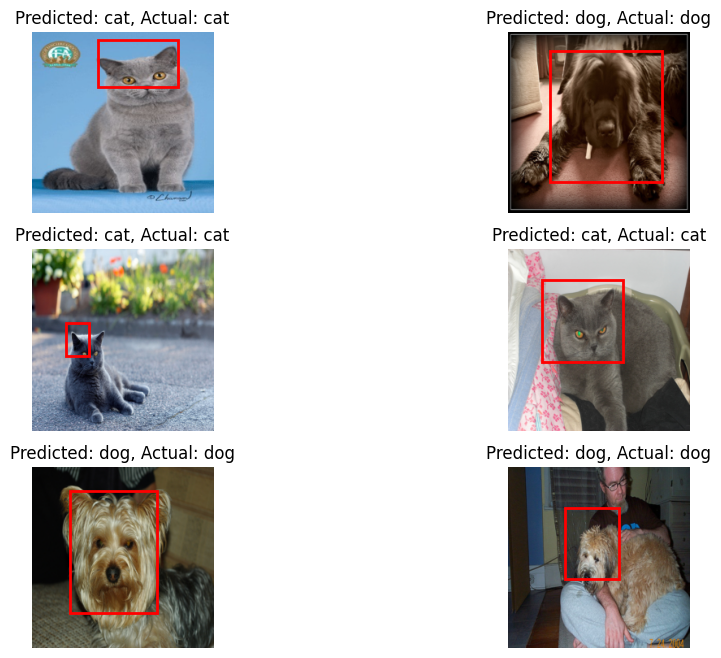

In [17]:
visualize_predictions_with_bbox(model, val_loader, num_images=6)